# MLOps for RSEs - 4. Model Evaluation & Reuse

In this third part of the tutorial, we'll look at some of the practices and tools that are used after the machine learning model is trained. These activities are generally about evaluating the performance of the model, understanding the results it produces and sharing the outputs so the model and its predictions can be reused. The FAIR principles are hopefully well known to most RSEs, and their application to both code and data. In a machine learning-based project it is important to apply FAIR principle to machine learning models and other ML assets to promote reproducible research and general reuse of research assets.

![Met Office Logo](https://www.metoffice.gov.uk/webfiles/1661941781161/images/icons/social-icons/default_card_315.jpg)

### Key Principles
* *Reusability* - Make trained models, model results, performance metrics and explainability metrics easily  available to other researchers.
* *Scalability* - Produce and serve results at scale, either for large datasets and problems or for many users simultaneously.
* *Interactivity* - Make research outputs available through an interactive interface for to facilitate exploration and use of results in an intuitive way that does not distract from thinking about the actual problem the researcher is interested in.

### Key Tasks for RSEs
* Setting up infrastructure to serve models and model results
* Creating model evaluation and testing suites/workflows to evaluate model performance in a reproducible and comparable way
* Supporting tools for interpretability and explainability (XAI)
* Creating dashboard for ML outputs including
  * predictions from inference
  * performance metrics
  * explainability metrics


### Key Terms
* *inference* - producing predictions from the trained machine learning model
* *Explainable AI (XAI)* - A machine learning pipeline where the predictions made by the algorithm can be explained and interpreted (what does this prediction mean in terms of the problem domain?).
* *Explainability* - Part of XAI which enables some one to explain how a machine learning algorithm made a certain prediction, such as which inputs were important, which particular parts of a neural network or decision tree were activated etc.
* *Interpretability* - Part of XAI which tell us what a particular prediction mean in the original problem domain and generally understanding the performance of the model in the research context.
* *metrics* - values which characterise some aspect of the model and its results.


### Key Tools
* model storage/loading ([MLflow](https://mlflow.org/), [onnx](https://github.com/onnx))
  * model registry ([ML Flow models](https://www.mlflow.org/docs/latest/models.html))
* inference ([MLflow](https://mlflow.org/), [ray serve](https://docs.ray.io/en/latest/serve/index.html))
* workflow mangers/engines ([ray](https://docs.ray.io/))
* metrics ([scikit learn](https://scikit-learn.org/))
* XAI ([scikit learn](https://scikit-learn.org/), [shap](https://shap.readthedocs.io/en/latest/index.html), [omni xai](https://github.com/salesforce/OmniXAI))
* dashboards ([matplotlib](https://www.google.com/search?q=matplotlib&oq=matplotlib&aqs=chrome..69i57j0i131i433i512j69i59l2j0i131i433i512j69i65l3.2614j0j7&sourceid=chrome&ie=UTF-8), [holoviz](https://holoviz.org/))

### Running this notebook
This notebook should run from a conda environment created with the [requirements_evaluation.yml file](requirements_evaluation.yml). See the [readme file](https://github.com/informatics-lab/ukrse_2022_mlops_walkthrough/blob/main/README.md) for info on how to set up a conda environment for using this notebook.

## Loading trained models for inference

Once you've trained a model, or more usually in a research several different models to explore different options for you model such as different model architectures, different input features or different training datasets, you then want to evaluate the performance of each model (using performance metrics) and also understand how it is making predictions (using interpretability and explainability techniques).

In [1]:
import datetime
import os
import pathlib
import functools

In [2]:
import intake

In [3]:
import numpy
import pandas

In [4]:
import matplotlib
import matplotlib.pyplot

In [5]:
import sklearn
import sklearn.preprocessing
import sklearn.metrics

## Get train and test data

First we load the data, both input data to feed in to the model and target data with which to compare results to assess performance. We will again load the data from the catalog we created in the data preparation phase.

In [6]:
try:
    rse_root_data_dir = pathlib.Path(os.environ['RSE22_ROOT_DATA_DIR'])
    print('reading from environment variable')
except KeyError as ke1:
    rse_root_data_dir = pathlib.Path(os.environ['HOME'])  / 'data' / 'ukrse2022'
    print('using default path')
rse_root_data_dir

using default path


PosixPath('/home/h01/shaddad/data/ukrse2022')

In [7]:
rotors_catalog = intake.open_catalog(rse_root_data_dir / 'rotors_catalog.yml')
rotors_catalog 

rotors_catalog:
  args:
    path: /home/h01/shaddad/data/ukrse2022/rotors_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [8]:
rotors_df = rotors_catalog['rotors_preprocessed'].read()

In [9]:
# one small bit of cleaning: ensuring the correct datetime type for our time feature
rotors_df['time'] = pandas.to_datetime(rotors_df['time'])
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
u_wind_feature_names = [f'u_wind_{i1}' for i1 in range(1,23)]
v_wind_feature_names = [f'v_wind_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [10]:
train_df = rotors_df[rotors_df['time'] < datetime.datetime(2020,1,1,0,0)]
val_df = rotors_df[rotors_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [11]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_feature_names

In [12]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(train_df[[if1]])
    preproc_dict[if1] = scaler1

In [13]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(train_df[[target_feature_name]])


/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [14]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [15]:
X_train = preproc_input(train_df, preproc_dict)
y_train = numpy.concatenate(
    [preproc_target(train_df, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(train_df, target_encoder).reshape((-1,1))),],
    axis=1
)

/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
X_val = preproc_input(val_df, preproc_dict)
y_val = numpy.concatenate(
    [preproc_target(val_df, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(val_df, target_encoder).reshape((-1,1))),],
    axis=1
)

/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Load in trained model
We will now get a model from our most recent run, which will use to do inference and calculate metrics. In this example we are using the ML Flow Models module to load in the model which was saved as part of our training run. Saving and loading models through ML Flow models provides a consistent interface for interacting with ML models even if the you change the underlying framework used to train the model. In this notebook we will explore different ways of selecting and loading models, including:
* getting a model from a specific run of a specific experiment
* getting the latest run from a specific experiment
* searching for the best model from a specific experiment based on a specified metric
* getting a model by name from the model registry


(You will need to have the ML Flow server we set up and started in notebook 3 Model Development to run this code.)

First set up our access to the ML Flow server.

In [17]:
import mlflow
import mlflow.models

In [18]:
# mlflow_server_address = '127.0.0.1'
mlflow_server_address = '10.152.49.196'
mlflow_server_port = 5001
mlflow_server_uri = f'http://{mlflow_server_address}:{mlflow_server_port:d}'
mlflow_server_uri    

'http://10.152.49.196:5001'

In [19]:
mlflow.set_tracking_uri(mlflow_server_uri)

In [20]:
mlflow.list_experiments()

[<Experiment: artifact_location='/home/h01/shaddad/data/ukrse2022/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='/home/h01/shaddad/data/ukrse2022/1', experiment_id='1', lifecycle_stage='active', name='rse_mlops_demo_rotors', tags={}>]

### Get the latest experiment

In [21]:
rse_rotors_experiment_name = 'rse_mlops_demo_rotors'

In [22]:
rse_rotors_experiment = mlflow.get_experiment_by_name(rse_rotors_experiment_name)
rse_rotors_experiment

<Experiment: artifact_location='/home/h01/shaddad/data/ukrse2022/1', experiment_id='1', lifecycle_stage='active', name='rse_mlops_demo_rotors', tags={}>

In [23]:
latest_run_info  = sorted(mlflow.list_run_infos(rse_rotors_experiment.experiment_id), key=lambda run1: run1.end_time)[-1]
latest_run_info.run_id, datetime.datetime.fromtimestamp(latest_run_info.end_time / 1000)

('41f81b6a5eeb4f71baa4b6d831fb2a65',
 datetime.datetime(2023, 1, 26, 21, 23, 36, 459000))

In [24]:
rse_rotors_model = mlflow.keras.load_model(latest_run_info.artifact_uri + '/model')
rse_rotors_model

2023-01-26 22:27:00.770871: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
rse_rotors_model.predict(X_val)

array([[2.72976613e-05, 9.99972701e-01],
       [2.38170382e-04, 9.99761879e-01],
       [6.93214592e-04, 9.99306798e-01],
       ...,
       [1.37432714e-08, 1.00000000e+00],
       [1.78137689e-05, 9.99982238e-01],
       [1.51072545e-02, 9.84892726e-01]], dtype=float32)

Alternatively we can access the model through the URI specified as `runs:/{run_id}` as described in the [ML Flow concepts page](https://www.mlflow.org/docs/latest/concepts.html)

In [26]:
latest_run_saved_model_uri = f'runs:/{latest_run_info.run_id}/model'
latest_run_saved_model_uri

'runs:/41f81b6a5eeb4f71baa4b6d831fb2a65/model'

In [27]:
mlflow.keras.load_model(latest_run_saved_model_uri).predict(X_val)

array([[2.72976613e-05, 9.99972701e-01],
       [2.38170382e-04, 9.99761879e-01],
       [6.93214592e-04, 9.99306798e-01],
       ...,
       [1.37432714e-08, 1.00000000e+00],
       [1.78137689e-05, 9.99982238e-01],
       [1.51072545e-02, 9.84892726e-01]], dtype=float32)

### Using the MLFlow model wrapping interface

You can use the ML Flow models module to be able to use models from different frameworks interchangeably for inference purposes.

In [28]:
logged_model = latest_run_saved_model_uri



In [29]:
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.keras
  run_id: 41f81b6a5eeb4f71baa4b6d831fb2a65

In [30]:
sum(loaded_model.predict(X_val).argmax(axis=1) == 1)


2899

In [31]:
loaded_model.predict(X_val)

array([[2.72976613e-05, 9.99972701e-01],
       [2.38170382e-04, 9.99761879e-01],
       [6.93214592e-04, 9.99306798e-01],
       ...,
       [1.37432714e-08, 1.00000000e+00],
       [1.78137689e-05, 9.99982238e-01],
       [1.51072545e-02, 9.84892726e-01]], dtype=float32)

In [32]:
sum(y_val[:,0]), sum(y_val[:,1]), y_val.shape

(129.0, 2784.0, (2913, 2))

### Working with the ML Flow Client object and ML Flow UI

The `MlflowClient` class gives us more general and low level access to the artifacts stored by the ML Flow server. Here we will use it to access a particular registered model and also to search for the best model from all the runs in an experiment. A registered model is one from a particular run that we have decided to be of some significance. Usually at some point in a project you might decide that a particular model is best for some reason (usually performance according to the chosen metric for the project). A model registry is a bit like for model what a catalogue is for data. One could image a research group maintaining a collective model registry to go with its collective data catalogue for commonly used datasets and code repository for common code.,


In [33]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_server_uri)
mlflow_client

In [34]:
mlflow_client.list_registered_models()

[<RegisteredModel: creation_timestamp=1674770335000, description='', last_updated_timestamp=1674770335257, latest_versions=[<ModelVersion: creation_timestamp=1674770335257, current_stage='None', description='', last_updated_timestamp=1674770335257, name='rse_mlops_tutorial', run_id='41f81b6a5eeb4f71baa4b6d831fb2a65', run_link='', source='/home/h01/shaddad/data/ukrse2022/1/41f81b6a5eeb4f71baa4b6d831fb2a65/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>], name='rse_mlops_tutorial', tags={}>]

In [35]:
[(m1.name, m1.version) for m1 in mlflow_client.list_registered_models()[0].latest_versions]

[('rse_mlops_tutorial', '1')]

In [36]:
latest_run_info.artifact_uri

'/home/h01/shaddad/data/ukrse2022/1/41f81b6a5eeb4f71baa4b6d831fb2a65/artifacts'

In [37]:
mlflow.tracking.MlflowClient().get_run(latest_run_info.run_id)

<Run: data=<RunData: metrics={'loss': 0.017196469008922577,
 'root_mean_squared_error': 0.13113531470298767,
 'val_loss': 0.03678085282444954,
 'val_root_mean_squared_error': 0.1917833536863327}, params={'batch_size': '1000',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.0001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.0',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.log-model.history': '[{"run_id": "41f81b6a5eeb4f71baa4b6d831fb2a65", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2023-01-26 21:23:22.647292", "flavors": '
                             '{"kera

### Searching for the best model

Once you've done various training runs, perhaps varying the architecture, hyperparameters, input data or just using different random initialisations, you will have multiple runs in your experiment (and also possibly multiple experiments). You may then want to retrieve the model that is the best or highest scoring according some metric of interest, which you may do multiple times for different metrics of interest.

In [38]:
mlflow_client.list_experiments()

[<Experiment: artifact_location='/home/h01/shaddad/data/ukrse2022/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='/home/h01/shaddad/data/ukrse2022/1', experiment_id='1', lifecycle_stage='active', name='rse_mlops_demo_rotors', tags={}>]

In [39]:
mlflow_client.list_experiments()[-1].experiment_id

'1'

In [40]:
mlflow_client.search_runs(mlflow_client.list_experiments()[-1].experiment_id, order_by=['metrics.val_loss'])

[<Run: data=<RunData: metrics={'loss': 0.017196469008922577,
  'root_mean_squared_error': 0.13113531470298767,
  'val_loss': 0.03678085282444954,
  'val_root_mean_squared_error': 0.1917833536863327}, params={'batch_size': '1000',
  'class_weight': 'None',
  'epochs': '100',
  'initial_epoch': '0',
  'max_queue_size': '10',
  'opt_amsgrad': 'False',
  'opt_beta_1': '0.9',
  'opt_beta_2': '0.999',
  'opt_decay': '0.0',
  'opt_epsilon': '1e-07',
  'opt_learning_rate': '0.0001',
  'opt_name': 'Adam',
  'sample_weight': 'None',
  'shuffle': 'True',
  'steps_per_epoch': 'None',
  'use_multiprocessing': 'False',
  'validation_batch_size': 'None',
  'validation_freq': '1',
  'validation_split': '0.0',
  'validation_steps': 'None',
  'workers': '1'}, tags={'mlflow.log-model.history': '[{"run_id": "41f81b6a5eeb4f71baa4b6d831fb2a65", '
                              '"artifact_path": "model", "utc_time_created": '
                              '"2023-01-26 21:23:22.647292", "flavors": '
          

### Loading a registered model

When you have a model that is performing well or is in some other way of significance

As a first option you can use the API to find the registered models and load one of them.

In [41]:
len(mlflow_client.list_registered_models()), [(m1.name, m1.latest_versions[-1].version) for m1 in mlflow_client.list_registered_models()]

(1, [('rse_mlops_tutorial', '1')])

Now we can load the model through the information in the registered model item of interest.

In [44]:
rotors_reg_model_name = 'rse_mlops_tutorial'
rotors_reg_model_version = '1'
reg_model_artifact_uri = f'models:/{rotors_reg_model_name}/{rotors_reg_model_version}'
reg_model_artifact_uri

'models:/rse_mlops_tutorial/1'

In [45]:
reg_model = mlflow.pyfunc.load_model(mlflow_client.get_registered_model(rotors_reg_model_name).latest_versions[0].source)

In [46]:
reg_model.predict(X_val)

array([[2.72976613e-05, 9.99972701e-01],
       [2.38170382e-04, 9.99761879e-01],
       [6.93214592e-04, 9.99306798e-01],
       ...,
       [1.37432714e-08, 1.00000000e+00],
       [1.78137689e-05, 9.99982238e-01],
       [1.51072545e-02, 9.84892726e-01]], dtype=float32)

## Evaluating Performance

Now that we have access to one or more trained models, typically we will want to calculate performance and explainability metrics with the models. For this example of our wind rotors models, we are going to calculate some [standard metrics for a classification problem](https://en.wikipedia.org/wiki/Precision_and_recall), such as 
* precision
* recall
* F1-score
* false alarm rate
* miss rate


We will also calculate a *domain specific* metric called [*Symmetric Exteremal Dependence Index*](https://www.ecmwf.int/en/newsletter/147/meteorology/use-high-density-observations-precipitation-verification#:~:text=The%20Symmetric%20Extremal%20Dependence%20Index,a%20threshold%20to%20be%20set), which is a metric specific to weather and climate problems, rather than a generic machine learning metric. Most research ML research problems should consider both standard ML metrics, as well the measures of algorithm performance that are specific to the problem domain e.g. meteorology, genetics, astrophysics, medicine etc.

As we can see from the output in the cells above, our model outputs a pseudo probability of a rotor being observed in a given time window, 

In [47]:
def calc_sedi(conf_mat):
    """
    Define a function to calculate the Symmetic Extermal Dependence Index (SEDI) from a confusion matrix
    """
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [48]:
y_result_val = rse_rotors_model.predict(X_val)[:,0] >2e-3 

<AxesSubplot: ylabel='None'>

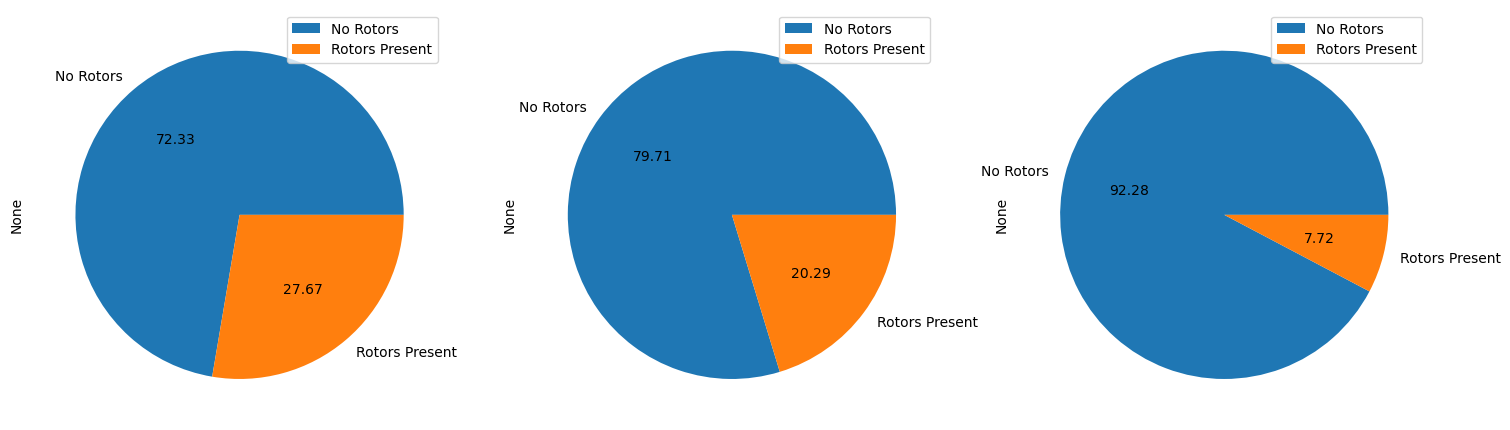

In [49]:
fig1 = matplotlib.pyplot.figure('comparison of class frequencies for different thresholds', figsize=(18,6))
ax1 = fig1.add_subplot(1,3,1)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-3 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)
ax1 = fig1.add_subplot(1,3,2)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-2 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)
ax1 = fig1.add_subplot(1,3,3)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-1 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)


For this model, we can choose different threshold to classify the result as *no rotors* vs *rotors present*. With different choices of threshold, we will get different metric results. We can choose the threshold that gives us the best performance for our particular requirements for the classifier.

In [50]:
y_train_pred_raw = rse_rotors_model.predict(X_train)[:,0]
y_val_pred_raw = rse_rotors_model.predict(X_val)[:,0]

In [51]:
thresholds_list = list(numpy.arange(1e-3,0.3,1e-3))

In [52]:
labels_for_conf_mat_shape = list(numpy.unique(y_val))

In [53]:
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in numpy.arange(1e-3,0.3,1e-3):
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train[:,0], y_pred_train, labels_for_conf_mat_shape)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_val = list(map(float, y_val_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_val[:,0], y_pred_val, labels_for_conf_mat_shape)
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/h01/shaddad/.conda/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as key

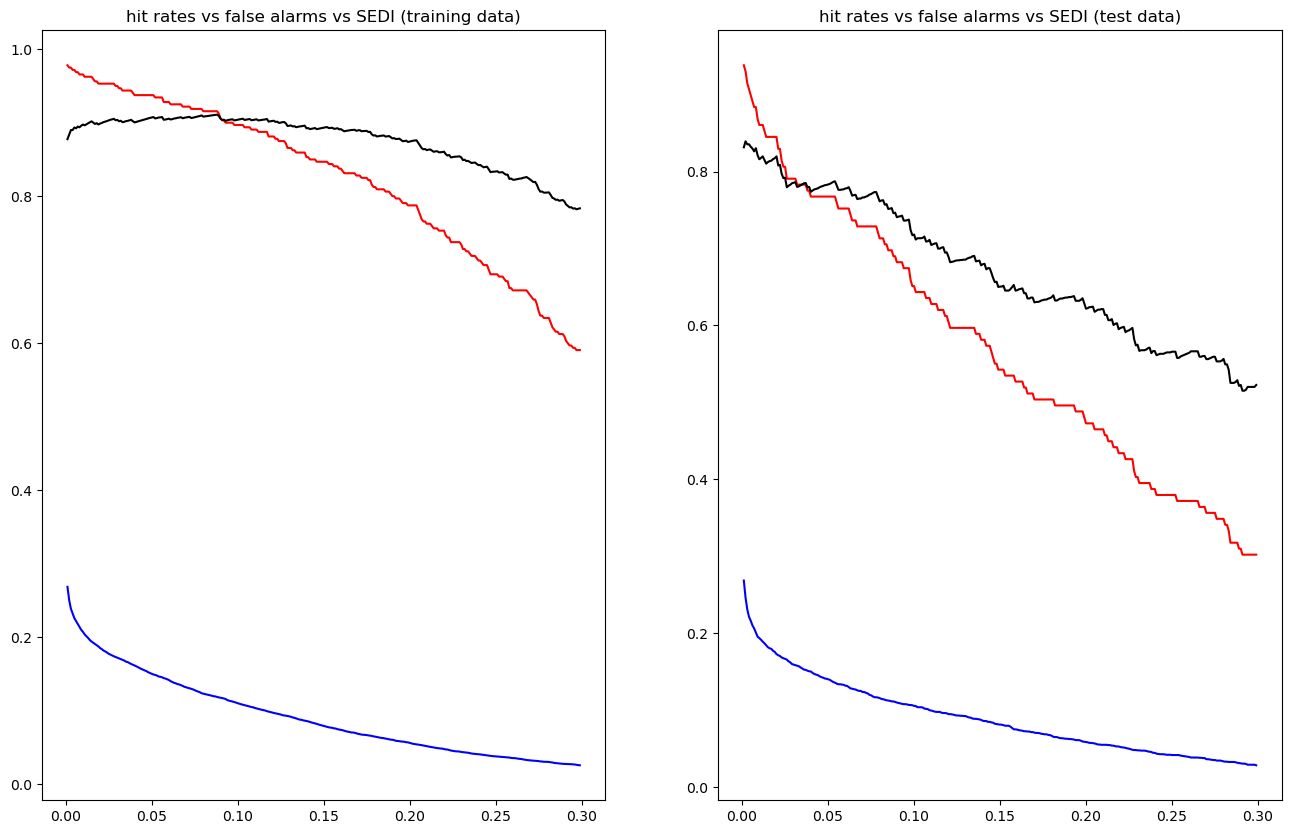

In [54]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms vs SEDI (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms vs SEDI (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

### Example - Dashboard to visualise results

In any research project we want to share the results with others working on the project, in our research group, current and future collaborators and other researchers around the world in the same field. To do that, we don't just want to be able plot the results as we did above for ourselves, which we may do for creating reports and papers, but ideally make it possible for others to interactively explore the results through a *results dashboard*. Here will use the same tool (panel from the holoviz ecosystem) that we used in the notebook 2 to create a dashboard for data exploration to create a dashboard to enable researchers to explore the results of the trained machine learning model. 

In [55]:
import panel

In [56]:
panel.extension()

In [57]:
def plot_rotors_metrics(rotors_model,  X_dict, y_dict, selected_split, threshold,):
    y_raw = rotors_model.predict(X_dict[selected_split])[:,0]
    y_pred = list(map(float, y_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_dict[selected_split], y_pred)
    metric_dict = {
        'hit_rate' : [cm1[1,1] / (cm1[1,0] + cm1[1,1])],
        'false_alarm_rate' : [cm1[0,1] / (cm1[0,0] + cm1[0,1])],
        'sedi_score': [calc_sedi(cm1)],
    }
    
    fig1 = matplotlib.pyplot.Figure()
    ax1 = fig1.add_subplot(1,1,1)
    pandas.DataFrame.from_dict(metric_dict).transpose().plot.bar(ax=ax1)
    ax1.set_ylim([0.0, 1.0])
    fig1.tight_layout()
    return fig1


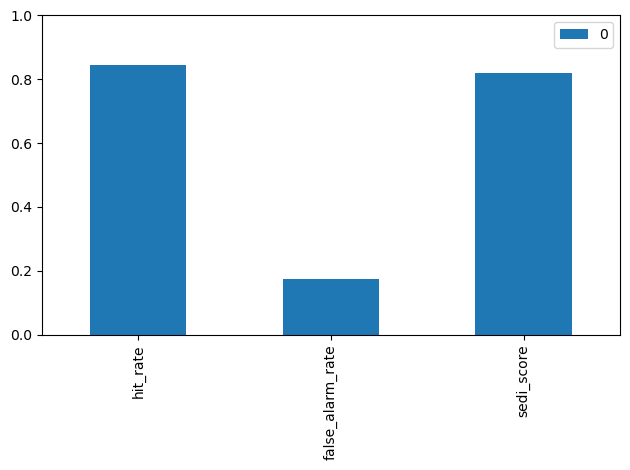

In [58]:
plot_rotors_metrics(
    rotors_model=rse_rotors_model,
    X_dict= {'train': X_train, 'val': X_val},
    y_dict= {'train': y_train[:,0], 'val': y_val[:,0]},
    selected_split='val',
    threshold=0.02,
)

In [59]:
split_select_widget = panel.widgets.Select(options=['train', 'val'])

In [60]:
threshold_widget = panel.widgets.slider.FloatSlider(start=0.0,end=0.2,step=0.001, value=0.01)

In [61]:
metric_plotter = panel.bind(
    functools.partial(plot_rotors_metrics, 
                      rotors_model=rse_rotors_model,
                      X_dict= {'train': X_train, 'val': X_val},
                      y_dict= {'train': y_train[:,0], 'val': y_val[:,0]},),
    selected_split=split_select_widget,
    threshold=threshold_widget,    
)

In [62]:
metric_dashboard = panel.Column(panel.Row(split_select_widget, threshold_widget), metric_plotter)

Column
    [0] Row
        [0] Select(options=['train', 'val'], value='train')
        [1] FloatSlider(end=0.2, step=0.001, value=0.01)
    [1] ParamFunction(function)
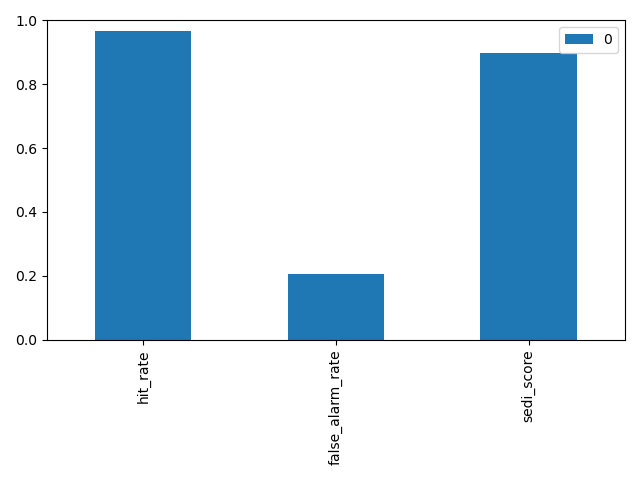

In [63]:
metric_dashboard.servable()

Our very basic dashboard is:
* loading data from a catalog
* loading a pre-trained model from catalog of pretrained models
* display plots  created on demand through an interactive dashboard.

Although this seems very simple (well, it is), this is a very scalable approach. We can easily make this better by
* Using a larger dataset.
* scaling up the calculation required through a workflow engine (e..g. dask, ray)
* run this on the cloud
* use more complicated/interesting plots



# Example - Explainable AI

Lastly we'll briefly touch on an important emerging part of machine learning called interpretability or explainability or explainable AI (XAI). This aims to open up the "black box" of the machine learning algorithms and try to understand how predictions are made and what they mean. Often this resolves in understanding the contribution or importance of a particular feature or data point in the training set. In many ways this is calculated and displayed and stored in the same way as the performance metrics displayed above, so from a workflow or engineering perspective it is perhaps not that noteworthy. It is an increasingly important and impactful part of a machine learning pipeline and researchers are generally now expected to include some aspect of XAI in any publications for research depending on machine learning, so it is important for RSEs to be aware of this important class of tools which they will likely have to support in ML projects, including seamless scaling up on XAI computation and being able to do these calculations in a reliable, reproducible way. 

Common tools
* [scikit learn permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
* [SHAP](https://shap.readthedocs.io/en/latest/index.html)
* [OmniXAI](https://github.com/salesforce/OmniXAI)



In [64]:
X_val.shape

(2913, 88)

In [65]:
import copy

In [66]:
recall_baseline = sklearn.metrics.recall_score(y_val[:,0] , reg_model.predict(X_val)[:,0] > 1e-2)

In [67]:
def calc_pfi_metric(rotors_reg_model_name, X_val, y_val, ix1, ix2):
    reg_model = mlflow.pyfunc.load_model(mlflow_client.get_registered_model(rotors_reg_model_name).latest_versions[0].source)
    pfi_X = copy.deepcopy(X_val)
    pfi_X[:,ix1] = X_val[:,ix2]
    pfi_X[:,ix2] = X_val[:,ix1]
    recall_accum = sklearn.metrics.recall_score(y_val[:,0] , reg_model.predict(pfi_X)[:,0] > 1e-2)
    return recall_accum


In [68]:
import random

In [69]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
%%time
recall_average_changes = numpy.zeros(X_val.shape[1])
for ix1 in range(X_val.shape[1]):
    print(ix1)
    recall_diffs = sum([calc_pfi_metric(rotors_reg_model_name, 
                                        X_val, 
                                        y_val, 
                                        ix1, 
                                        random.randint(0,87)) - recall_baseline 
                        for i2 in range(3)])
    recall_average_changes[ix1] =  recall_diffs / 3.0
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
CPU times: user 8min 46s, sys: 27.9 s, total: 9min 14s
Wall time: 4min 20s


<AxesSubplot: >

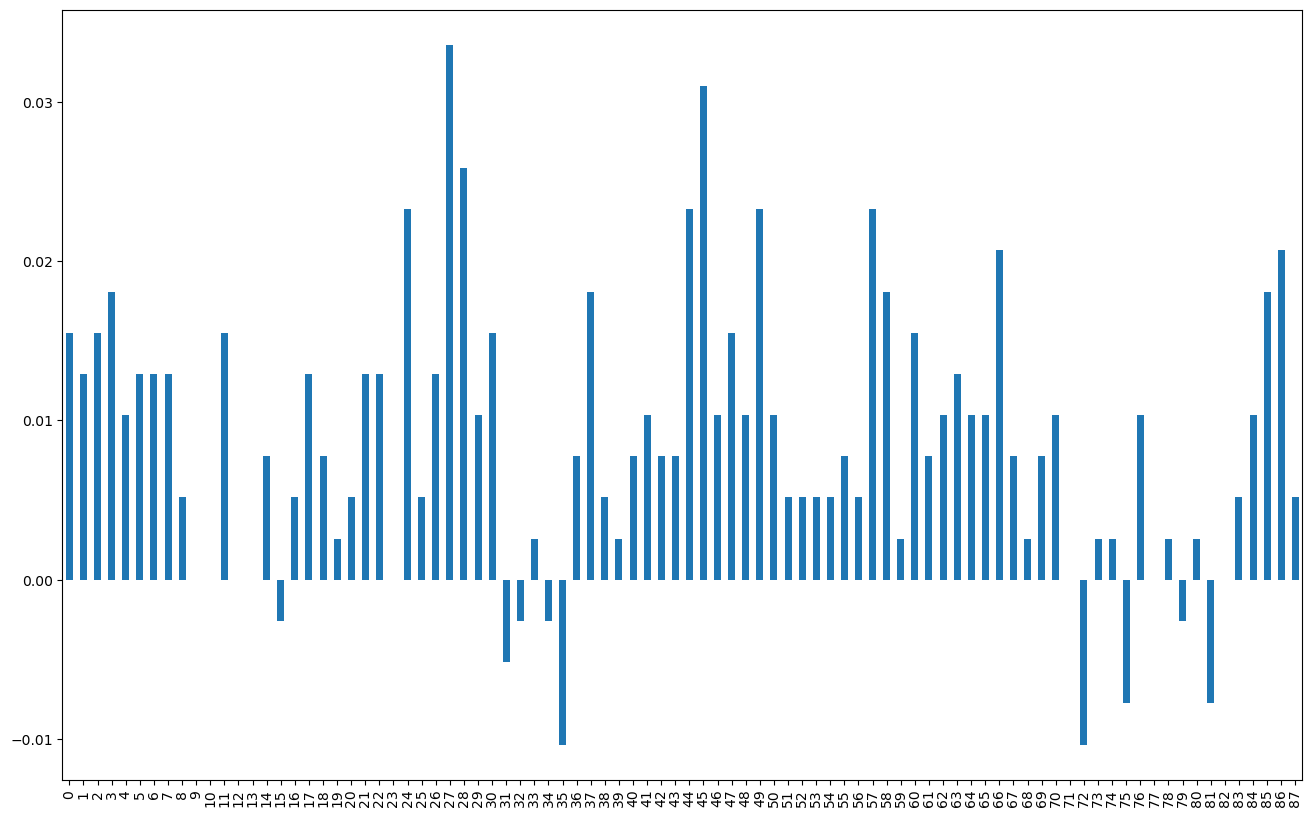

In [71]:
pandas.Series(recall_average_changes).plot.bar(figsize=(16,10))

## Further reading

* [Explainable AI - Towards Data Science](https://towardsdatascience.com/what-is-explainable-ai-xai-afc56938d513)

### Reference

* [Holoviz](https://holoviz.org/) 
* [ML Flow Models](https://www.mlflow.org/docs/latest/models.html)
* [scikit learn model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
* [OmniXAI](https://github.com/salesforce/OmniXAI)